In [125]:
from datetime import datetime, timedelta
from sqlmodel import Field, Relationship, SQLModel, Session, create_engine, select, col

CYCLE_TIME = 1      # times in hours
db_name = "beboundless_data.db"
sqlite_url = f"sqlite:///{db_name}"
engine = create_engine(sqlite_url)

In [126]:
from beboundless_data_db import Requestors, Orders

one_hour_ago = int((datetime.now() - timedelta(hours=CYCLE_TIME)).timestamp())
with Session(engine) as session:
    statement = select(Requestors).where(Requestors.last_activity >= one_hour_ago)
    results: list[Requestors] = session.exec(statement).all()

address = [r.address for r in results if r.address]
print(address)

data_dict = {}
with Session(engine) as session:
    for addr in address:
        statement = select(Orders).where(
            Orders.created >= one_hour_ago,
            Orders.requestor_address == addr,
            Orders.lock_gas_price != None
        )
        orders = session.exec(statement).all()
        data_dict[addr] = [(order.order_id, order.created, order.lock_txn, order.lock_gas_price) for order in orders if order.lock_gas_price]
print(data_dict)

[]
{}


In [127]:
# blacklist = [
#     "0x734df7809c4ef94da037449c287166d114503198",
#     "0x89f12aba0bcda3e708b1129eb2557b96f57b0de6"
# ]
# data_dict = {addr: orders for addr, orders in data_dict.items() if addr not in blacklist}

whitelist = [
    "0x2546c553d857d20658ece248f7c7d0861a240681",
    "0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0",
]
data_dict = {addr: orders for addr, orders in data_dict.items() if addr in whitelist}

print(data_dict)

{}


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame([
    {"address": addr, "order_id": oid, "created": created, "lock_txn": txn, "lock_gas_price": float(gas)}
    for addr, lst in data_dict.items()
    for oid, created, txn, gas in lst
])

from dc_view import plot_gas_price_boxplot, compute_gas_group_stats, filter_good_suppliers

print("Group stats:")
group_stats = compute_gas_group_stats(df)
print(group_stats)

print("Good suppliers:")
good = filter_good_suppliers(group_stats, min_count=10, max_std=5)
print(good)

print("Gas price boxplot:")
plot_gas_price_boxplot(df)

Group stats:


KeyError: 'address'

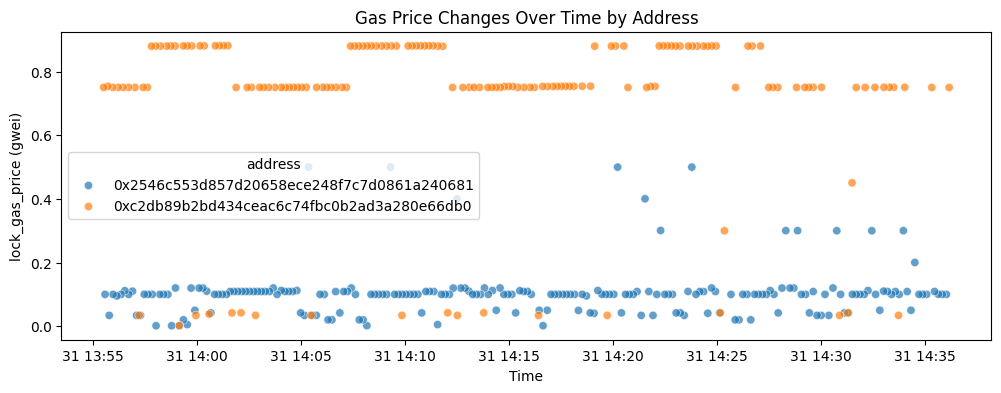

In [ ]:
df["created_dt"] = pd.to_datetime(df["created"], unit="s")
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df, x="created_dt", y="lock_gas_price", hue="address", alpha=0.7)
plt.title("Gas Price Changes Over Time by Address")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()

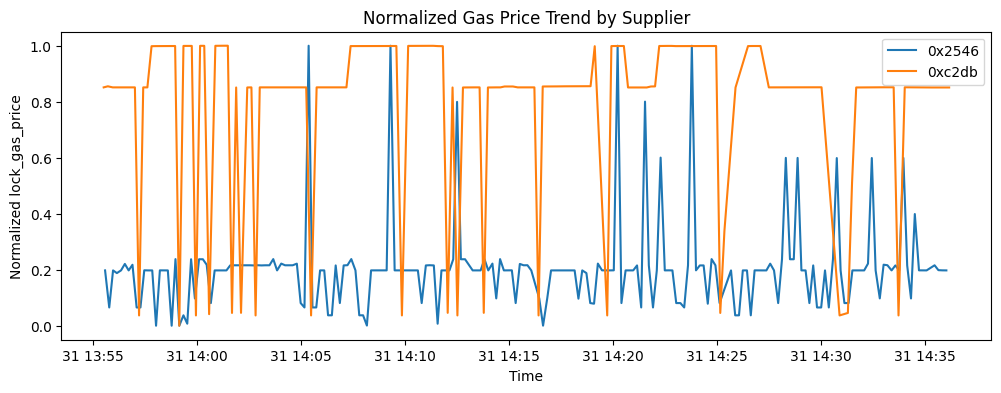

In [ ]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    norm = (group["lock_gas_price"] - group["lock_gas_price"].min()) / (group["lock_gas_price"].max() - group["lock_gas_price"].min())
    plt.plot(group["created_dt"], norm, label=addr[:6])
plt.legend()
plt.title("Normalized Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("Normalized lock_gas_price")
plt.show()

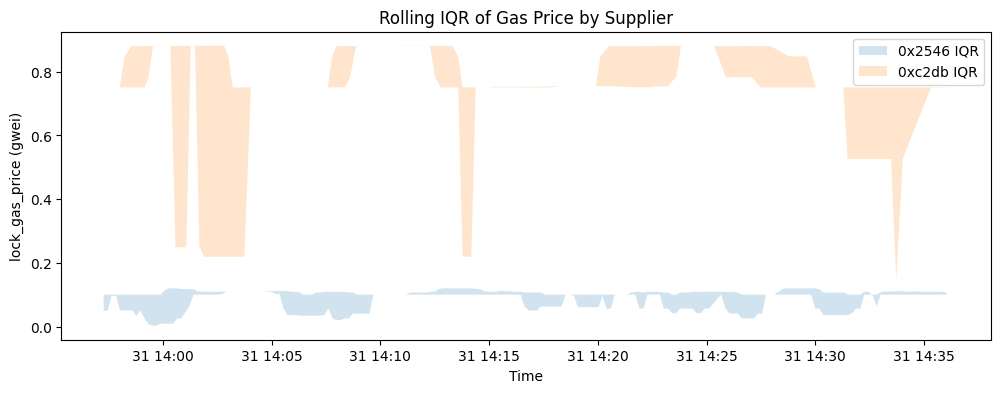

In [ ]:
window = 10
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    rolling_q25 = group["lock_gas_price"].rolling(window).quantile(0.25)
    rolling_q75 = group["lock_gas_price"].rolling(window).quantile(0.75)
    plt.fill_between(group["created_dt"], rolling_q25, rolling_q75, alpha=0.2, label=f"{addr[:6]} IQR")
plt.legend()
plt.title("Rolling IQR of Gas Price by Supplier")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()


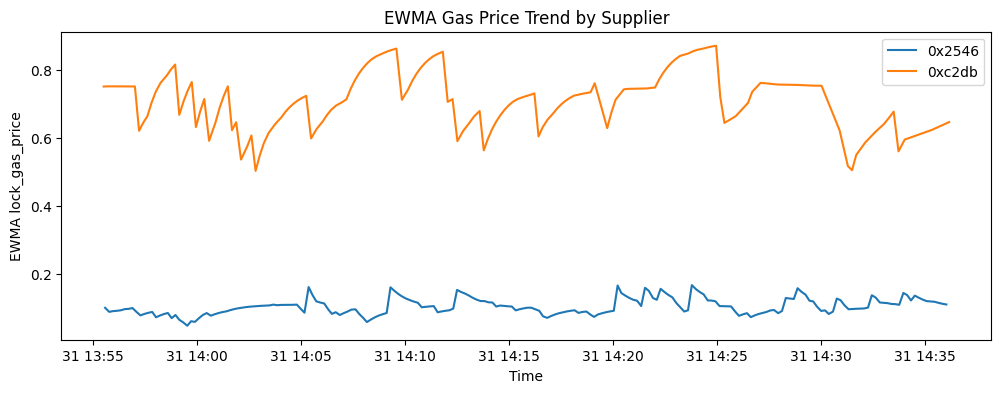

In [ ]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    ewma = group["lock_gas_price"].ewm(span=10, adjust=False).mean()
    plt.plot(group["created_dt"], ewma, label=addr[:6])
plt.legend()
plt.title("EWMA Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("EWMA lock_gas_price")
plt.show()
